In [200]:
import pandas as pd
import matplotlib.pyplot as plt
from config import config
import seaborn as sns

## Read evaluation results

In [201]:
df_results = pd.read_csv('results/results.csv')
df_results = df_results.set_index(['Strategy','Ticker'])

## Calulate values for the portfolio

In [202]:
grouped = df_results.groupby(level='Strategy')
def calc_return(group):
    strategy = group.index.get_level_values('Strategy')[0]
    portfolio = {
        'Return': [(group['Value_e'].sum() / group['Value_s'].sum() * 100) - 100],
        'Value_s': [group['Value_s'].sum()],
        'Value_e': [group['Value_e'].sum()],
        'SLVL_mean': [group['SLVL_mean'].mean()],
        'Stop count': [group['Stop count'].sum()]
    }
    
    portfolio_df = pd.DataFrame(portfolio)
    portfolio_df.index = pd.MultiIndex.from_tuples([(strategy, 'Portfolio')], names=['Strategy', 'Ticker'])
    
    return pd.concat([group, portfolio_df])    

df_results = grouped.apply(calc_return)
df_results.reset_index(level=0, drop=True, inplace=True)

## Calculate mean values

In [203]:
grouped = df_results.groupby(level='Strategy')
def calc_mean(group):
    # Filter out the 'Portfolio' index from the group
    group_without_portfolio = group[group.index.get_level_values('Ticker') != 'Portfolio']
    
    # Calculate the mean of the remaining group
    mean = pd.DataFrame(group_without_portfolio.mean().to_frame().T)
    
    # Set the new index for the mean row
    mean.index = pd.MultiIndex.from_tuples([(group.index.get_level_values('Strategy')[0], 'Portfolio_mean')], names=['Strategy', 'Ticker'])
    
    # Concatenate the original group with the mean
    return pd.concat([group, mean])
df_results = grouped.apply(calc_mean)
df_results.reset_index(level=0, drop=True, inplace=True)

## Visualize performance comparision between tickers with positive and negative market returns

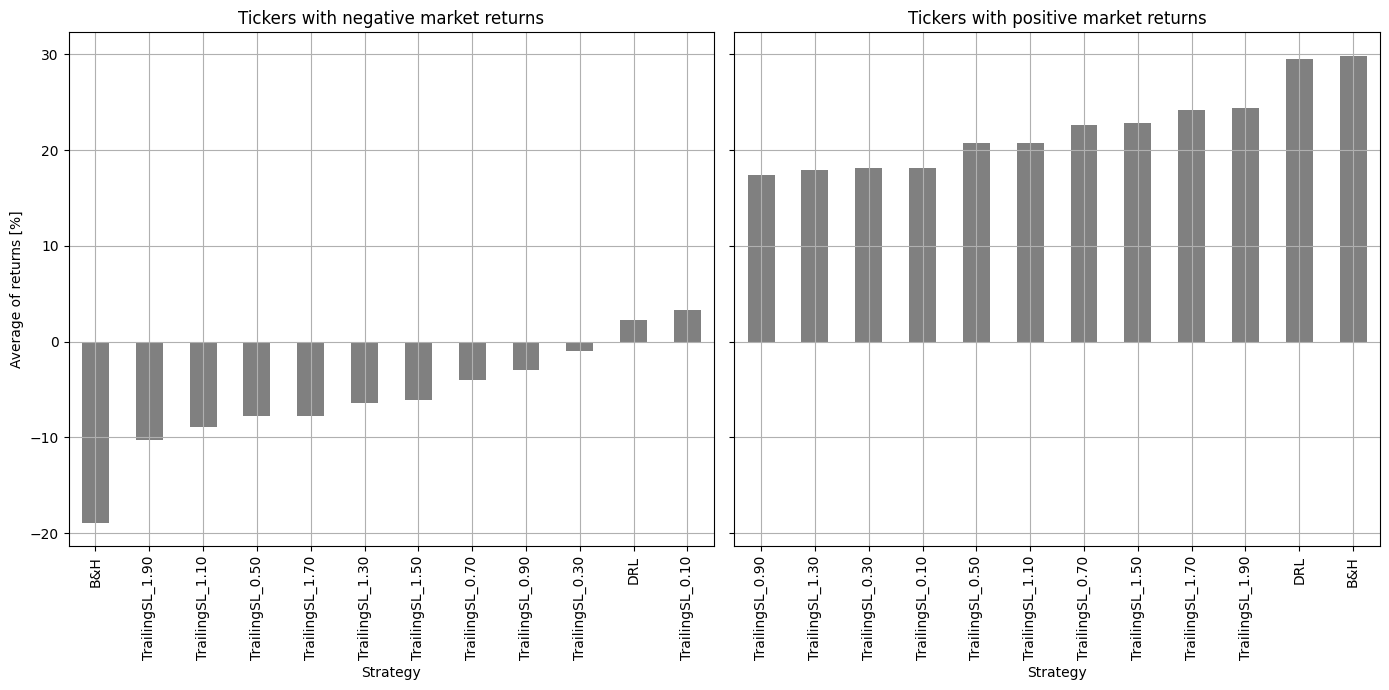

In [204]:
# Extract B&H returns
bh_returns = df_results.loc[pd.IndexSlice['B&H', :], 'Return']
bh_returns = bh_returns[~bh_returns.index.isin(['Portfolio', 'Portfolio_mean'], level='Ticker')]

# Categorize tickers based on B&H returns
low_market_tickers = bh_returns[bh_returns < .0].index.get_level_values('Ticker')
high_market_tickers = bh_returns[bh_returns > .0].index.get_level_values('Ticker')

# Filter based on strategies
analysis = df_results.loc[pd.IndexSlice[[f'TrailingSL_{pct:.2f}' for pct in config['stop_pct']] + ['DRL', 'B&H'], :], ['Return']].sort_index()
# Calculate average returns for low and high market conditions
low_market_returns = analysis.loc[pd.IndexSlice[:, low_market_tickers], :].groupby(level='Strategy').mean().sort_values(by=['Return'])
high_market_returns = analysis.loc[pd.IndexSlice[:, high_market_tickers], :].groupby(level='Strategy').mean().sort_values(by=['Return'])

# Create a bar chart to compare the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

low_market_returns.plot(kind='bar', ax=ax[0], legend=False, color='gray')
ax[0].set_title('Tickers with negative market returns')
ax[0].set_ylabel('Average of returns [%]')
ax[0].grid(True)

high_market_returns.plot(kind='bar', ax=ax[1], legend=False, color='gray')
ax[1].set_title('Tickers with positive market returns')
ax[1].grid(True)
plt.tight_layout()

plt.savefig('charts/returns_bar.eps', format='eps', dpi=300, bbox_inches='tight')

plt.show()

## Probability distribution of various strategy reuturns

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


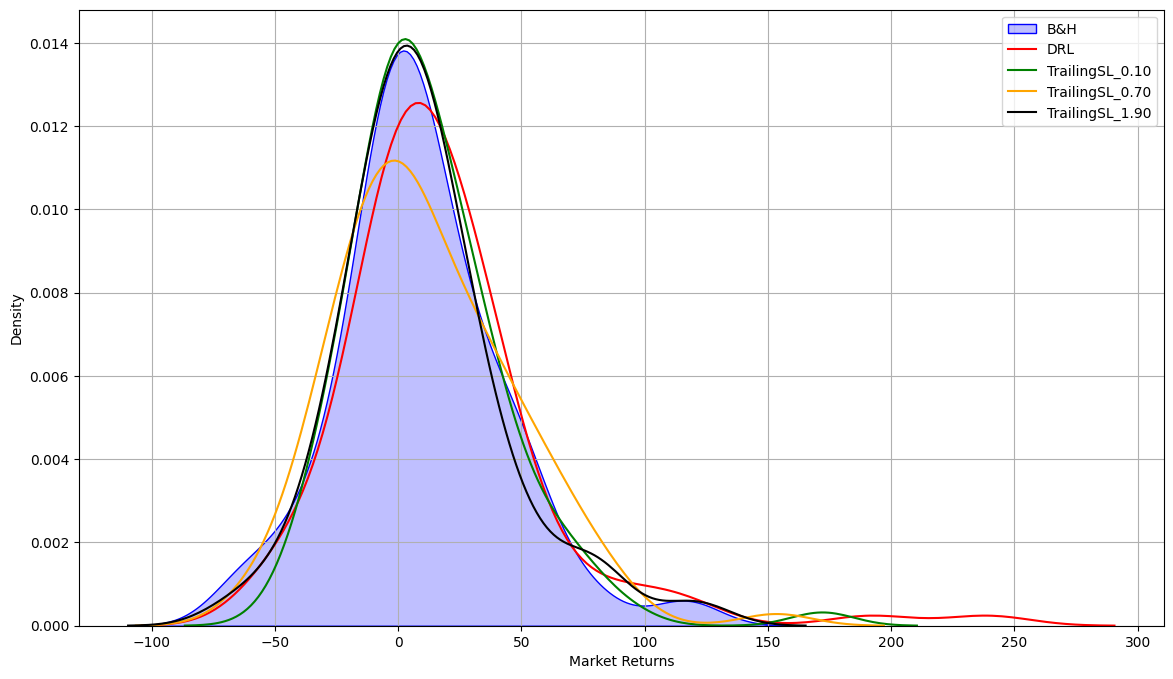

In [205]:
# Extracting returns for each strategy
bh_returns = df_results.loc[pd.IndexSlice['B&H', :], 'Return']
drl_returns = df_results.loc[pd.IndexSlice['DRL', :], 'Return']
ts_returns1 = df_results.loc[pd.IndexSlice['TrailingSL_0.10', :], 'Return']
ts_returns2 = df_results.loc[pd.IndexSlice['TrailingSL_0.30', :], 'Return']
ts_returns3 = df_results.loc[pd.IndexSlice['TrailingSL_0.50', :], 'Return']
ts_returns4 = df_results.loc[pd.IndexSlice['TrailingSL_0.70', :], 'Return']
ts_returns5 = df_results.loc[pd.IndexSlice['TrailingSL_0.90', :], 'Return']
ts_returns6 = df_results.loc[pd.IndexSlice['TrailingSL_1.10', :], 'Return']
ts_returns7 = df_results.loc[pd.IndexSlice['TrailingSL_1.30', :], 'Return']
ts_returns8 = df_results.loc[pd.IndexSlice['TrailingSL_1.50', :], 'Return']
ts_returns9 = df_results.loc[pd.IndexSlice['TrailingSL_1.70', :], 'Return']
ts_returns10 = df_results.loc[pd.IndexSlice['TrailingSL_1.90', :], 'Return']

# Plotting the KDE of market returns with labels and different colors
plt.figure(figsize=(14, 8))
sns.kdeplot(bh_returns, fill=True, color='blue', label='B&H')
sns.kdeplot(drl_returns, fill=False, color='red', label='DRL')
sns.kdeplot(ts_returns1, fill=False, color='green', label='TrailingSL_0.10')
sns.kdeplot(ts_returns4, fill=False, color='orange', label='TrailingSL_0.70')
sns.kdeplot(ts_returns10, fill=False, color='black', label='TrailingSL_1.90')

plt.xlabel('Market Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('charts/returns_distribution.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Results summary - Sharpe ratio

In [206]:
representatives = ['PYPL', 'IDXX', 'AEP', 'LIN', 'VRTX', 'Portfolio', 'Portfolio_mean']

df_short_results = df_results.loc[pd.IndexSlice[:,representatives], :]
short_sharpe_results = df_short_results['Sharpe'].to_frame(name='Sharpe')
short_sharpe_results = short_sharpe_results.unstack(level='Ticker')
short_sharpe_results = short_sharpe_results.sort_values(by=('Sharpe', 'Portfolio_mean'), ascending=False)
short_sharpe_results.drop(columns=[('Sharpe','Portfolio')], inplace=True)
with open('tables/sharpe_short.tex','w') as file:
    file.write(short_sharpe_results.to_latex(float_format="%.2f"))
short_sharpe_results

Sharpe                                          \
Ticker               PYPL      IDXX       AEP       LIN      VRTX   
Strategy                                                            
TrailingSL_0.10 -1.084891  0.155812  0.617156  0.976159  1.391245   
TrailingSL_1.10 -1.455681 -0.148939 -0.041850  1.019986  1.269691   
FixedSL_1.30    -1.103180  0.014953  0.091373  0.240397  2.304272   
FixedSL_1.50    -0.954819 -0.008338  0.177917  0.240068  3.010360   
DRL             -0.961641  0.008021  0.301620  1.096558  1.281177   
TrailingSL_1.50 -1.043649 -0.216189  0.327449  1.451388  2.264890   
FixedSL_0.70    -0.828709 -0.146971  0.190598  0.246624  2.968955   
FixedSL_0.90    -0.902699 -0.068460  0.160339  0.266524  2.900333   
FixedSL_1.10    -0.944075  0.012246  0.125787  0.258490  3.025254   
FixedSL_0.50    -0.966090 -0.015426  0.221282 -0.083166  3.040014   
FixedSL_1.90    -1.013953 -0.095391  0.098665  0.273703  2.939748   
FixedSL_1.70    -0.970848 -0.036121  0.123830  0.294580  2.974760   
TrailingSL_1.70 -0.702823 -0.283471  0.477496  1.239436  2.215583   
TrailingSL_1.30 -1.224549 -0.296124  0.379943  1.174399  1.967438   
FixedSL_0.10    -0.852301  0.029732  0.270106 -0.042589  3.104295   
TrailingSL_0.50 -1.290642 -0.311291  0.708359  0.771160  1.644720   
TrailingSL_0.90 -1.644844 -0.028975  0.078134  1.003806  1.505073   
B&H             -1.171490  0.051572  0.218234  0.645612  3.029634   
TrailingSL_0.70 -0.779623  0.290249  0.313323  0.801800  2.043847   
FixedSL_0.30    -0.931790  0.006515  0.253472 -0.088282  3.086002   
TrailingSL_1.90 -1.016158 -0.255703  0.254996  0.715748  3.378693   
TrailingSL_0.30 -1.310804 -0.013074 -0.269558  1.056374  1.925284   

                                
Ticker          Portfolio_mean  
Strategy                        
TrailingSL_0.10       0.419058  
TrailingSL_1.10       0.336728  
FixedSL_1.30          0.313380  
FixedSL_1.50          0.309649  
DRL                   0.307998  
TrailingSL_1.50       0.306513  
FixedSL_0.70          0.304952  
FixedSL_0.90          0.302268  
FixedSL_1.10          0.295789  
FixedSL_0.50          0.282968  
FixedSL_1.90          0.278307  
FixedSL_1.70          0.276632  
TrailingSL_1.70       0.274577  
TrailingSL_1.30       0.267975  
FixedSL_0.10          0.257968  
TrailingSL_0.50       0.257103  
TrailingSL_0.90       0.253144  
B&H                   0.247093  
TrailingSL_0.70       0.232182  
FixedSL_0.30          0.223706  
TrailingSL_1.90       0.215606  
TrailingSL_0.30       0.122113

## Results summary - returns

In [207]:
short_returns_results = df_short_results['Return'].to_frame(name='Return')
short_returns_results = short_returns_results.unstack(level='Ticker')
short_returns_results = short_returns_results.sort_values(by=('Return', 'Portfolio_mean'), ascending=False)
with open('tables/cum_ret_short.tex','w') as file:
    file.write(short_returns_results.to_latex(float_format="%.2f"))
short_returns_results

Return                                               \
Ticker                PYPL       IDXX        AEP        LIN        VRTX   
Strategy                                                                  
DRL             -45.937058  -0.838319   6.186358  41.990570   41.051572   
TrailingSL_0.10 -30.058379  -1.173018  13.010852  36.104234   59.006810   
TrailingSL_0.70 -42.454746  11.964576   9.199797  25.759250   50.254913   
TrailingSL_1.70 -47.155219 -18.217896   9.511097  39.572524   72.422108   
TrailingSL_1.50 -50.261244 -11.751137   5.038284  33.526964   56.776838   
TrailingSL_0.30 -49.025472  -7.682644 -13.660517  16.815634   69.963865   
TrailingSL_1.90 -57.134668 -18.371653   4.811865  26.764762   75.366423   
B&H             -68.879484 -10.313768   5.064392  25.893203  120.277342   
TrailingSL_0.90 -28.381385  -9.462359   0.584665  35.612104   51.037494   
TrailingSL_0.50 -47.938818 -13.674681  13.217876  28.502448   46.685619   
TrailingSL_1.10 -43.315038 -12.639871  -4.706627  36.907254   41.587859   
TrailingSL_1.30 -47.275692 -28.274364   7.935280  25.591932   59.622919   
FixedSL_1.10    -54.795274  -9.702689   2.175546   9.186895  109.695640   
FixedSL_1.70    -65.928839 -19.344751   2.158194  10.932246  109.186899   
FixedSL_0.90    -49.869605 -19.501616   3.110962   9.602065  108.334860   
FixedSL_1.50    -60.582945 -12.224918   3.651548   8.216847  109.569318   
FixedSL_0.70    -54.341956 -35.872442   3.891580   8.557356  109.092346   
FixedSL_1.30    -58.758020  -9.962162   1.214365   8.309108  102.266388   
FixedSL_0.10    -63.781042 -10.792383   5.685623 -10.000008  110.516534   
FixedSL_1.90    -66.178588 -27.756688   1.411384   9.924598  108.804481   
FixedSL_0.50    -54.716309 -15.793585   4.648435 -12.733367  109.851206   
FixedSL_0.30    -59.122004 -13.326795   5.409418 -13.730150  110.329173   

                                           
Ticker           Portfolio Portfolio_mean  
Strategy                                   
DRL              25.842701      17.852072  
TrailingSL_0.10  20.924414      11.800638  
TrailingSL_0.70  25.882188      11.243236  
TrailingSL_1.70  16.040080      10.510278  
TrailingSL_1.50  18.450671      10.453664  
TrailingSL_0.30  20.459134       9.941365  
TrailingSL_1.90  15.319516       9.589755  
B&H              12.375549       9.015018  
TrailingSL_0.90  23.676241       8.709090  
TrailingSL_0.50  24.987885       8.532654  
TrailingSL_1.10  17.935656       8.095426  
TrailingSL_1.30  16.100856       7.522376  
FixedSL_1.10      7.577006       5.545555  
FixedSL_1.70      6.608351       5.419756  
FixedSL_0.90      7.482406       5.298042  
FixedSL_1.50      6.701116       4.607907  
FixedSL_0.70      5.164982       4.540274  
FixedSL_1.30      5.853636       4.507389  
FixedSL_0.10     -0.899961       3.325070  
FixedSL_1.90      5.301931       3.184060  
FixedSL_0.50      3.754163       3.152738  
FixedSL_0.30      1.441988       1.829207